**Installing the Required Modules**

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing the Required Modules**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer, RobustScaler

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import ShuffleSplit,  cross_val_score

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.inspection import permutation_importance

from sklearn.svm import SVC

import optuna

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 4)
pd.set_option("plotting.backend", "matplotlib")

from google.colab import drive
drive.mount('/drive')

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


**Freeze Random State**

In [3]:
np.random.seed(35)

**Utility Functions**

In [4]:
def get_dataset_part(df, part_sz=.2):
   temp_df = df.copy()
   _, out_df = train_test_split(temp_df, test_size=part_sz,  stratify=temp_df[["model"]])
   y = out_df["model"].values.ravel()
   #анонимизиуем данные
   dropped_lst = ["machineID", 'datetime', 'RULWeek', \
                            'failure', 'failed', 'RUL', 'RUL_I', "model" ]
   out_df.drop(dropped_lst, axis=1, inplace=True)
   return out_df, y

# **I. Goal**

Цель нашей работы построить классификатор моделей оборудования по имеющимся телеметрическим данным: https://www.kaggle.com/datasets/tiagotgoz/predictive-useful-life-based-into-telemetry

# **II. Approaches and Limitations**

В качестве классификатора был выбран SCV
Из за ограничения на время исполнения кода в  Google Collab классификатор будет обучаться без использования каких либо стратегий по типу One-vs-the-Rest / One-vs-One  стратегий

# **1. Data Transformers**

## **1.1 Datatime Transformers**

In [5]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

## **1.2 Utility Transformers**

In [6]:
def identy_transformer():
  return FunctionTransformer(lambda x: x)

## **1.3 Full Dataset Transformer**

In [7]:
transform = make_column_transformer(
   (OrdinalEncoder(), ["age"]),
   (sin_transformer(365), ["time_in_cycles"]),
   (cos_transformer(365), ["time_in_cycles"]),
   (RobustScaler(),
     [ "voltmean_24h","rotatemean_24h" ,"pressuremean_24h",
      "vibrationmean_24h", "voltsd_24h", "rotatesd_24h",
      "pressuresd_24h", "vibrationsd_24h", "voltmean_5d", "rotatemean_5d",
      "pressuremean_5d", "vibrationmean_5d", "voltsd_5d", "rotatesd_5d",
      "pressuresd_5d","vibrationsd_5d", "volts_entropy", "volts_benford",
      "volts_cidce", "volts_lzc", "press_max", "press_below", "press_above",
      "press_entropy", "press_benford", "press_cidce", "press_lzc",
      "vibra_max", "vibra_below", "vibra_above", "vibra_entropy",
      "vibra_benford", "vibra_cidce", "vibra_lzc", "rotate_max", "rotate_below",
      "rotate_above", "rotate_entropy", "rotate_benford", "rotate_cidce",
      "rotate_lzc","volts_max", "volts_below", "volts_above", "DI",
      ]),
    (identy_transformer(), ["error1", "error2","error3", "error4", "error5",
                           "comp1", "comp2", "comp3", "comp4"]))

# **2. Classificator Fitting**

## **2.1 Pipeline Creation**

In [8]:
model = SVC()
classify= make_pipeline(transform, model)

## **2.2 Model Fitting and Data Anonymization**

In [9]:
TRAIN_PATH = "/drive/My Drive/rul/train_telemetry.csv"
TEST_PATH = "/drive/My Drive/rul/test_telemetry.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

X_train = train_df
X_test  = test_df

X_train["model"] = X_train["model"] -1
X_test["model"] = X_test["model"] -1


#select a subsample to configure hyperparameters
X_opt, y_opt = get_dataset_part(train_df)

Y_train = X_train["model"].values.astype(np.float).ravel()
Y_test = X_test["model"].values.astype(np.float).ravel()

#data anonymization
dropped_lst = ["machineID", "datetime", "RULWeek", "failure", "failed",
                "RUL", "RUL_I", "model"]

X_train = X_train.drop(dropped_lst, axis=1)
X_test = X_test.drop(dropped_lst, axis=1)

classify.fit(X_train, Y_train);

Y_pred = classify.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.58      0.34      0.43      1368
         1.0       0.48      0.04      0.08      1432
         2.0       0.43      0.73      0.54      2862
         3.0       0.54      0.53      0.54      2755

    accuracy                           0.48      8417
   macro avg       0.51      0.41      0.39      8417
weighted avg       0.50      0.48      0.44      8417



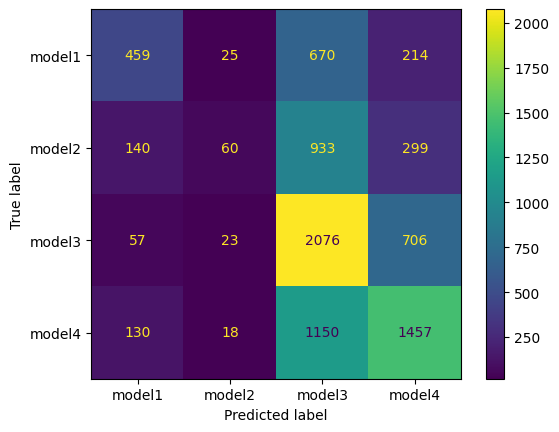

In [10]:
cls= ["model1", "model2", "model3", "model4"]
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)
disp.plot()

Как видно мы хорошо предсказываем 3 и 4 модели оборудования и совсем плохо вторую модель. Попробуем это в дальнейшем исправить

## **2.3 Features Importance**

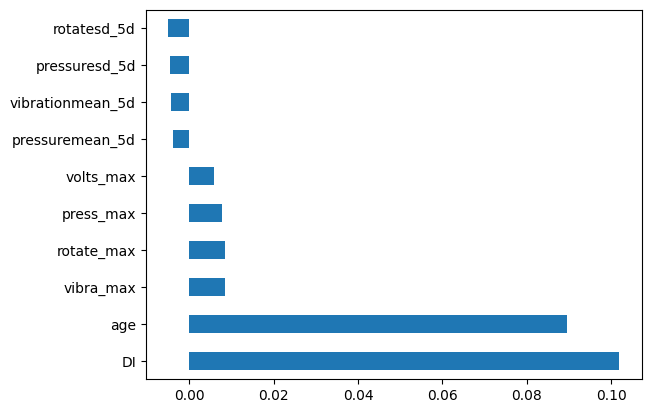

In [11]:
N_LARGEST = 10

COLUMN_NAMES = X_train.columns
perm_importance = permutation_importance(classify, X_test, Y_test,  n_jobs=-1, max_samples =.3)

feat_importances = pd.Series(perm_importance.importances_mean, COLUMN_NAMES)
feat_importances.nlargest(N_LARGEST).plot(kind='barh')
plt.show()

# **3. Classification Finetuning**

## **3.1 Objective Function**

In [13]:
class SVCObjective:

   def __init__(self, X, Y):
      self.X = X
      self.Y = Y

   def __call__(self, trial):
     C = trial.suggest_int('C', 1, 20)
     kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf'])
     degree = trial.suggest_int("degree", 1, 3)
     gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

     model = SVC(kernel=kernel, C=C, degree=degree, gamma=gamma, probability=True)

     pipeline = make_pipeline(transform, model)

     cv = ShuffleSplit(n_splits=5)
     score = cross_val_score(pipeline, self.X, self.Y,
                          scoring=make_scorer(f1_score, average="micro"), cv=cv)
     f1 = score.mean()
     return f1

## **3.2 Finetuning**

In [14]:
objective = SVCObjective(X_opt, y_opt)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
params = study.best_trial.params

[I 2023-06-19 14:43:02,238] A new study created in memory with name: no-name-b01957ab-88b5-400c-972f-8984394daf95
[I 2023-06-19 14:44:04,542] Trial 0 finished with value: 0.4519083969465649 and parameters: {'C': 14, 'kernel': 'rbf', 'degree': 1, 'gamma': 'auto'}. Best is trial 0 with value: 0.4519083969465649.
[I 2023-06-19 14:45:02,489] Trial 1 finished with value: 0.48244274809160304 and parameters: {'C': 15, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto'}. Best is trial 1 with value: 0.48244274809160304.
[I 2023-06-19 15:05:23,126] Trial 2 finished with value: 0.4661577608142494 and parameters: {'C': 17, 'kernel': 'linear', 'degree': 1, 'gamma': 'scale'}. Best is trial 1 with value: 0.48244274809160304.
[I 2023-06-19 15:06:21,816] Trial 3 finished with value: 0.44173027989821884 and parameters: {'C': 3, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}. Best is trial 1 with value: 0.48244274809160304.
[I 2023-06-19 15:07:14,683] Trial 4 finished with value: 0.48244274809160304 and para

# **4. Classifier With Best Hyperparameters**

In [17]:
classify= make_pipeline(transform, SVC(**params))
classify.fit(X_train, Y_train);
Y_pred = classify.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.56      0.57      1368
         1.0       0.50      0.42      0.46      1432
         2.0       0.61      0.68      0.64      2862
         3.0       0.65      0.64      0.64      2755

    accuracy                           0.60      8417
   macro avg       0.58      0.58      0.58      8417
weighted avg       0.60      0.60      0.60      8417



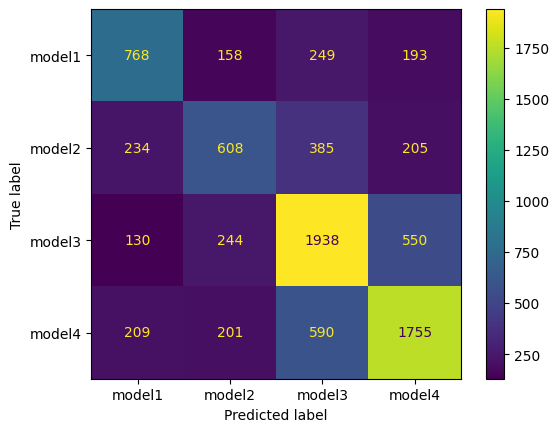

In [18]:
cls= ["model1", "model2", "model3", "model4"]
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)
disp.plot()

Как видим мы значительно улучшили качество предсказаний как для первой так и для второй моделей

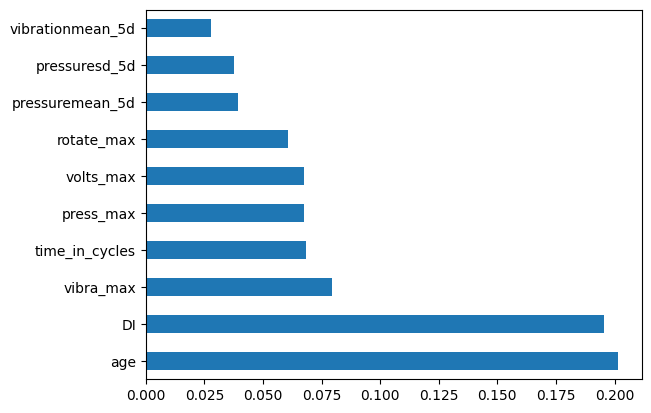

In [19]:
N_LARGEST = 10

COLUMN_NAMES = X_train.columns
perm_importance = permutation_importance(classify, X_test, Y_test,  n_jobs=-1, max_samples =.3)

feat_importances = pd.Series(perm_importance.importances_mean, COLUMN_NAMES)
feat_importances.nlargest(N_LARGEST).plot(kind='barh')
plt.show()